# Station Visualizer

This notebook generates a station map and a chart showing station distribution over time, for a given stage (raw, clean, QAQC, merge). Note that this reflects the information provided in station lists, and not actual station data availability (i.e., this figure should be re-made following the cleaning stage to reflect dropped stations and the actual temporal availability of data). 

In [19]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx
from collections import defaultdict

# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
RAW_DIR = "1_raw_wx"
CLEAN_DIR = "2_clean_wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
phase_dict = {"pull": RAW_DIR, "clean": CLEAN_DIR, "qaqc": QAQC_DIR, "merge": MERGE_DIR}


shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state"

In [14]:
station_list = pd.read_csv(
    f"s3://{BUCKET_NAME}/{RAW_DIR}/all_network_stationlist_pull.csv"
)

In [15]:
station_list.head(1)

,Unnamed: 0,name,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network
0,0,BOISE AIR TERMINAL/GOWEN FD AIRPORT,43.567,-116.241,860.5,1931-01-01 00:00:00+00:00,2023-03-22 00:00:00+00:00,Y,2023-03-23 21:42:22+00:00,ASOSAWOS


In [5]:
station_list['start-date']

0        1931-01-01 00:00:00+00:00
1        2006-01-01 00:00:00+00:00
2        2006-01-01 00:00:00+00:00
3        2006-01-01 00:00:00+00:00
4        2006-01-01 00:00:00+00:00
                   ...            
15875    2010-05-27 00:00:00+00:00
15876    2010-05-27 00:00:00+00:00
15877    2010-05-27 00:00:00+00:00
15878    2010-05-27 00:00:00+00:00
15879    2012-10-04 00:00:00+00:00
Name: start-date, Length: 15880, dtype: object

In [6]:
station_list["start-date"] = pd.to_datetime(station_list["start-date"], utc=True)
station_list["end-date"] = pd.to_datetime(station_list["end-date"], utc=True)

In [7]:
station_list["start-date"]

0       1931-01-01 00:00:00+00:00
1       2006-01-01 00:00:00+00:00
2       2006-01-01 00:00:00+00:00
3       2006-01-01 00:00:00+00:00
4       2006-01-01 00:00:00+00:00
                   ...           
15875   2010-05-27 00:00:00+00:00
15876   2010-05-27 00:00:00+00:00
15877   2010-05-27 00:00:00+00:00
15878   2010-05-27 00:00:00+00:00
15879   2012-10-04 00:00:00+00:00
Name: start-date, Length: 15880, dtype: datetime64[ns, UTC]

In [8]:
subdf = station_list.loc[~station_list["start-date"].isnull()].copy()

In [9]:
len(subdf)

15410

In [10]:
len(station_list)

15880

In [12]:
## Filter out non-downloaded rows
subdf = subdf.loc[subdf["pulled"] != "N"].copy()

In [13]:
len(subdf)

15394

In [16]:
stage_dict = {"pull": RAW_DIR, "clean": CLEAN_DIR, "qaqc": QAQC_DIR, "merge": MERGE_DIR}

In [17]:
stage_dict['pull']

'1_raw_wx'

## TESTING

In [20]:
def get_station_chart(phase,phase_dict):
    """
    Sums two input flag count dataframes. This is a helper function for sum_flag_counts().

    Parameters
    ----------
    phase: str
        "pull", "clean", "qaqc" or "merge"

    Returns
    -------
    out:

    """
    if phase not in ["pull", "clean", "qaqc", "merge"]:
        print(f"invalid phase:{phase}")
        return None

    ## Get station list
    directory = phase_dict[phase]
    station_list = pd.read_csv(
        f"s3://{BUCKET_NAME}/{directory}/all_network_stationlist_{phase}.csv"
    )

    # #! only in qaqc
    # # read in qaqc training station list
    # stns = pd.read_csv("../3_qaqc_data/qaqc_training_station_list.csv")

    # station_list = station_list[station_list["era-id"].isin(stns["era-id"])]
    # #! only in qaqc ^

    ## Get period

    # Format dates in datetime format (this gets lost in import).
    station_list["start-date"] = pd.to_datetime(station_list["start-date"], utc=True)
    station_list["end-date"] = pd.to_datetime(station_list["end-date"], utc=True)

    # Fix nas
    ## Filter out rows w/o start date
    # print(dffull[dffull['network']=="MARITIME"])
    subdf = station_list.loc[~station_list["start-date"].isnull()].copy()

    if phase == "pull":
        ## Filter out non-downloaded rows  #! raw only
        subdf = subdf.loc[subdf["pulled"] != "N"].copy()
    else:
        # Filter out non-cleaned rows #! clean and QAQC
        subdf = subdf.loc[subdf["cleaned"] != "N"].copy()

    # manually filter dates to >01-01-1980 and <today.
    # Timezones so far ignored here but we presume on the scale of month we can safely ignore them for the moment.
    # Note!: This implicitly assumes stations w/o end date run until present.
    subdf["start-date"] = subdf["start-date"].apply(
        lambda x: (
            x
            if x > datetime(1980, 1, 1, tzinfo=timezone.utc)
            else datetime(1980, 1, 1, tzinfo=timezone.utc)
        )
    )
    subdf["end-date"] = subdf["end-date"].apply(
        lambda x: (
            x
            if x < datetime.utcnow().replace(tzinfo=timezone.utc)
            else datetime.utcnow().replace(tzinfo=timezone.utc)
        )
    )

    # Get period of months for range of dates for each station
    subdf["period"] = [
        pd.period_range(*v, freq="M")
        for v in zip(subdf["start-date"], subdf["end-date"])
    ]

    subdf = subdf[subdf.period.str.len() > 0]
    subdf = subdf.reset_index(drop=True)

    if phase == "pull":
        #! from raw phase function
        out = subdf.explode("period").pivot_table(
            values="name",
            index="network",
            columns="period",
            aggfunc="count",
            fill_value=0,
        )
    else:
        #! from clean phase function
        out = subdf.explode("period").pivot_table(
            values="era-id",
            index="network",
            columns="period",
            aggfunc="count",
            fill_value=0,
        )

    return out

In [21]:
phase = 'pull'
test = get_station_chart(phase, phase_dict)

In [23]:
def plot_chart(phase, phase_dict):
    """
    Sums two input flag count dataframes. This is a helper function for sum_flag_counts().

    Parameters
    ----------
    phase: str
        "pull", "clean", "qaqc" or "merge"

    Returns
    -------
    out:

    """
    out = get_station_chart(phase, phase_dict)
    # Plot
    outt = out.T.reset_index()

    # Fix time component
    outt["date"] = outt["period"].astype(str)
    outt["date"] = pd.to_datetime(outt["date"])

    # Plot parameters
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.facecolor"] = "white"

    # Subplot parameters
    fig, ax = plt.subplots(figsize=(8, 6))
    outt.plot.area(
        x="date",
        title="Stations by network over time",
        ax=ax,
        x_compat=True,
        cmap="tab20c_r",
    )  # Get area plot
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))  # Fix legend
    ax.tick_params(labelcolor="black", labelsize="medium", width=3)
    ax.set_facecolor("w")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of stations")

    # Change axis bounds
    ax.set_xlim([date(1980, 1, 1), date(2022, 8, 1)])

    # Change tick marks
    ax.minorticks_on()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(3))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(matplotlib.dates.YearLocator(1))

    # Change y ticks
    plt.locator_params(axis="y", nbins=12)
    ax.yaxis.get_ticklocs(minor=True)

    # Set x axis labels
    # #plt.title("Stations Over Time By Network")
    plt.subplots_adjust(left=0.2, bottom=0.2, top=0.8, right=0.8)

    # Annotate text for total number
    # hard coding the number for now, come back to this
    plt.annotate(
        "Total # of QA/QC'd stations: 937", xy=(0.025, 0.95), xycoords="axes fraction"
    )

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format="png")
    img_data.seek(0)

    s3 = boto3.resource("s3")
    bucket = s3.Bucket(BUCKET_NAME)
    export_folder = phase_dict[phase]
    export_key = f"{export_folder}/{phase}_stations_over_time.png"
    # bucket.put_object(
    #     Body=img_data,
    #     ContentType="image/png",
    #     Key=export_key,
    # )

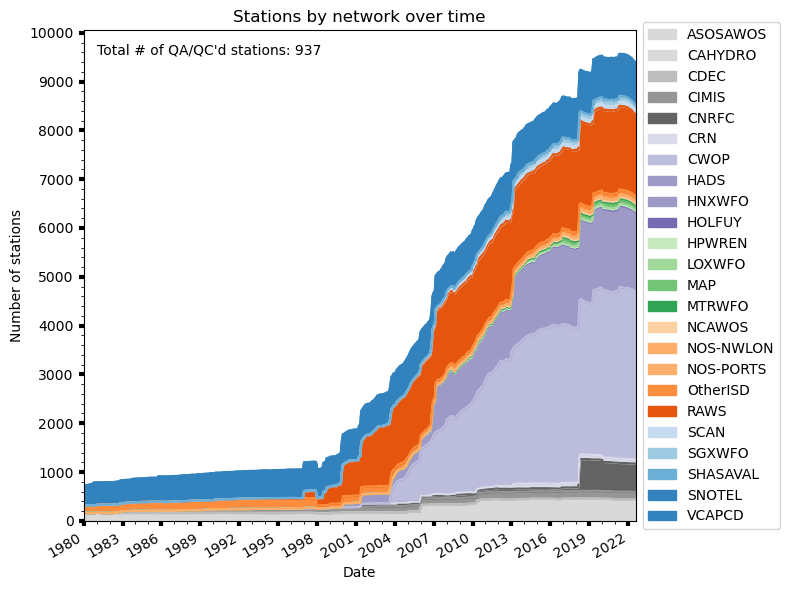

In [24]:
plot_chart(phase, phase_dict)

In [25]:
def get_station_map(phase, shapepath):
    """


    Parameters
    ----------
    phase: str
        "pull", "clean", "qaqc" or "merge"
    shapepath: string


    Returns
    -------
    out:

    """
    if phase not in ["pull", "clean", "qaqc", "merge"]:
        print(f"invalid phase:{phase}")
        return None

    ## Get station list
    directory = phase_dict[phase]
    station_list = pd.read_csv(
        f"s3://{BUCKET_NAME}/{directory}/all_network_stationlist_{phase}.csv"
    )

    ## Get period

    # Format dates in datetime format (this gets lost in import).
    station_list["start-date"] = pd.to_datetime(station_list["start-date"], utc=True)
    station_list["end-date"] = pd.to_datetime(station_list["end-date"], utc=True)

    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(
        station_list,
        geometry=gpd.points_from_xy(station_list.longitude, station_list.latitude),
    )
    gdf.set_crs(epsg=4326, inplace=True)  # Set CRS

    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857)  # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg=3857)
    gdf_us = gdf_wm.clip(us)

    # ------------------------------------------------------------------------------------------------------------
    # Version 1 - full map
    ax = gdf_us.plot(
        "network",
        figsize=(15, 15),
        alpha=1,
        markersize=3,
        legend=True,
        cmap="nipy_spectral",
    )
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format="png")
    img_data.seek(0)

    # s3 = boto3.resource("s3")
    # bucket = s3.Bucket(bucket_name)
    # bucket.put_object(
    #     Body=img_data, ContentType="image/png", Key="2_clean_wx/clean_station_map.png"
    # )

    # ------------------------------------------------------------------------------------------------------------
    # Version 2 - only big networks
    # Sort stations by number of networks
    gdf_us["network_count"] = gdf_us.groupby("network")["network"].transform(
        "count"
    )  # Add network count column.

    # If <100 stations, change to "misc"
    gdf_us.loc[gdf_us["network_count"] < 100, "network"] = "Misc"

    # Plot
    ax = gdf_us.plot(
        "network",
        figsize=(15, 15),
        alpha=1,
        markersize=3,
        legend=True,
        cmap="nipy_spectral",
    )
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format="png")
    img_data.seek(0)

    # s3 = boto3.resource("s3")
    # bucket = s3.Bucket(BUCKET_NAME)
    # bucket.put_object(
    #     Body=img_data,
    #     ContentType="image/png",
    #     Key="2_clean_wx/clean_station_map_min.png",
    # )

/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


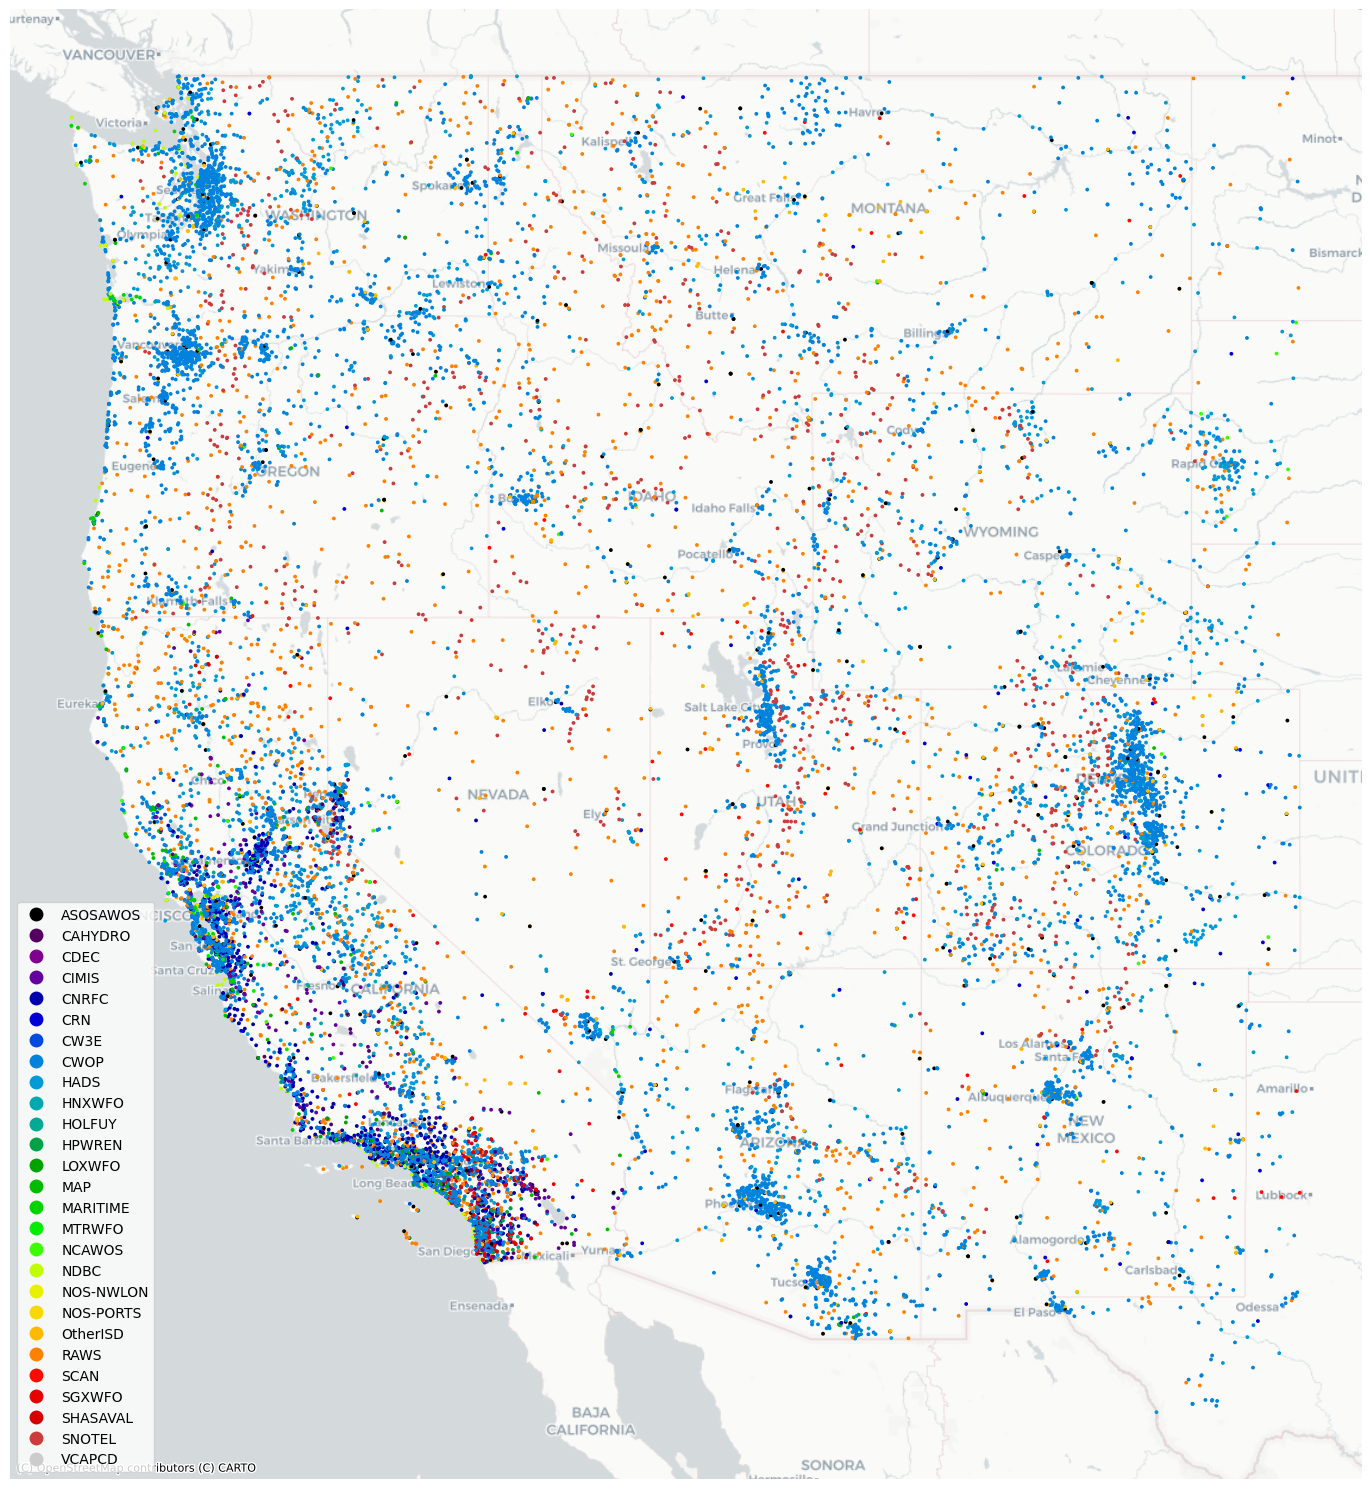

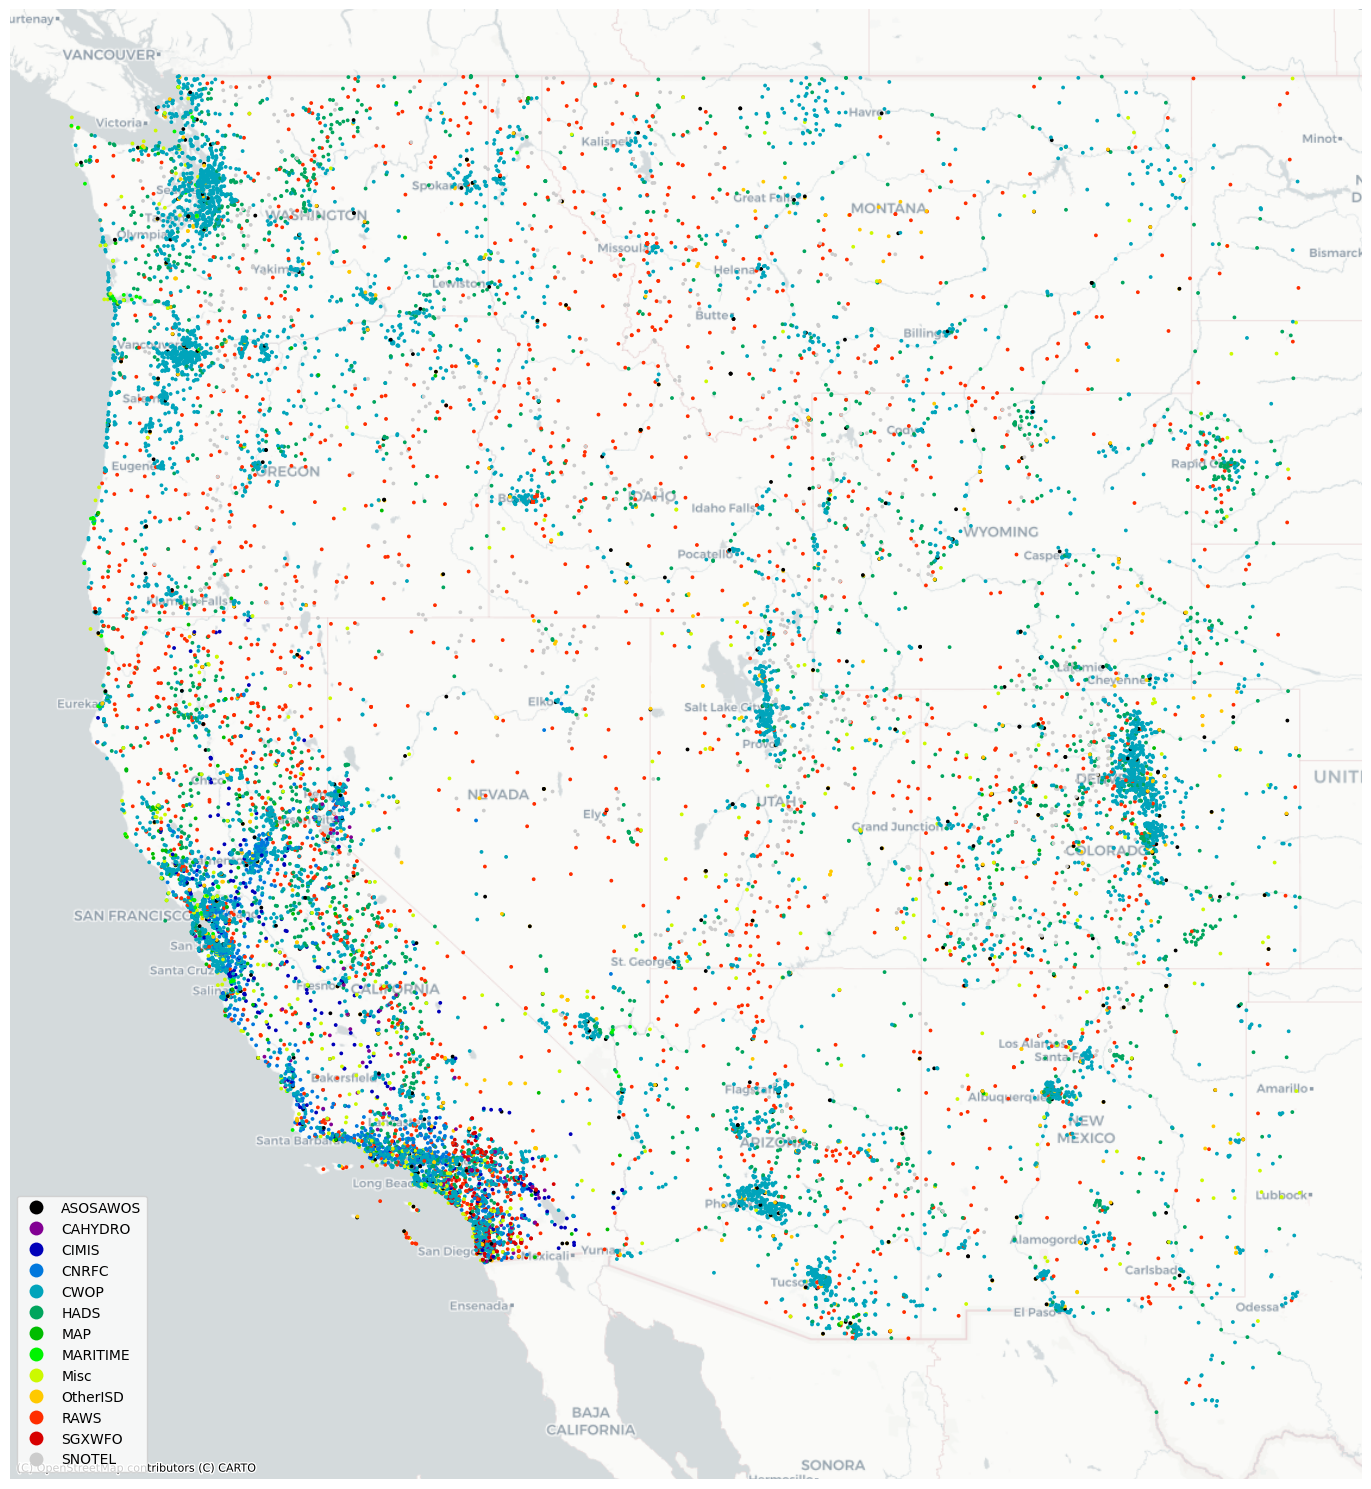

In [26]:
get_station_map('pull',shapepath)